In [1]:
import os
import sys
import h5py
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
from keras.models import Input, Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Activation, GRU, BatchNormalization
from keras.utils import Sequence
from keras import backend as K
from keras.optimizers import adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
from modis_utils.misc import cache_data, restore_data

In [4]:
scale_data = False

In [5]:
data = restore_data(os.path.join('cache', 'boundary_vectors_ALL.h5'))

In [6]:
train_boundary_vectors = data[0]
val_boundary_vectors = data[1]
test_boundary_vectors = data[2]

In [7]:
train_boundary_vectors.shape, val_boundary_vectors.shape, test_boundary_vectors.shape

((438, 1024, 2), (138, 1024, 2), (138, 1024, 2))

In [8]:
n_points = train_boundary_vectors.shape[1]

In [9]:
data_1 = np.concatenate(data, axis=0)

In [10]:
train_boundary_vectors = data_1[:-92]
val_boundary_vectors = data_1[-92:-46]
test_boundary_vectors = data_1[-46:]

In [11]:
train_boundary_vectors.shape, val_boundary_vectors.shape, test_boundary_vectors.shape

((622, 1024, 2), (46, 1024, 2), (46, 1024, 2))

In [12]:
def transform(data, scaler):
    old_shape = data.shape
    data = data.reshape(old_shape[0], -1)
    if scaler is not None:
        data = scaler.transform(data.astype(np.float))
    return data.reshape(old_shape)
    #return data

def transform_standardize(data, mean, std):
    old_shape = data.shape
    data = data.reshape(-1, old_shape[1]*old_shape[2])
    data = (data - mean)/std
    return data.reshape(old_shape)
    #return data

def find_mean_std(data):
    old_shape = data.shape
    data = data.reshape(-1, old_shape[1]*old_shape[2])
    mean = np.mean(data, axis=0).reshape(1, -1)
    std = np.std(data, axis=0).reshape(1, -1)
    std[std == 0] = 1
    #mean = mean.reshape(-1, old_shape[-1])
    #std = std.reshape(-1, old_shape[-1])
    return mean, std

In [13]:
scaler = None
scale_data = False
if scale_data:
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_boundary_vectors.reshape(train_boundary_vectors.shape[0], -1))

mean, std = find_mean_std(train_boundary_vectors)
train_boundary_vectors_1 = transform_standardize(train_boundary_vectors, mean, std)
val_boundary_vectors_1 = transform_standardize(val_boundary_vectors, mean, std)
test_boundary_vectors_1 = transform_standardize(test_boundary_vectors, mean, std)

In [14]:
def create_dataset(boundary_vectors_scale, timesteps):
    data_X = []
    data_Y = []
    for i in range(len(boundary_vectors_scale) - timesteps):
        data_x = boundary_vectors_scale[i:(i+timesteps)]
        data_y = boundary_vectors_scale[i + timesteps]
        data_X.append(data_x)
        data_Y.append(data_y)
    return np.asarray(data_X), np.asarray(data_Y)

In [15]:
'''
train_boundary_vectors_2 = train_boundary_vectors[24:,:,:].copy()
train_boundary_vectors_3 = train_boundary_vectors[46:].copy()
for i in range(len(train_boundary_vectors_3)):
    train_boundary_vectors_3[i] -= train_boundary_vectors_2[i%46]
'''

'\ntrain_boundary_vectors_2 = train_boundary_vectors[24:,:,:].copy()\ntrain_boundary_vectors_3 = train_boundary_vectors[46:].copy()\nfor i in range(len(train_boundary_vectors_3)):\n    train_boundary_vectors_3[i] -= train_boundary_vectors_2[i%46]\n'

In [16]:
from numpy import polyfit

In [17]:
plt.rcParams['figure.figsize'] = (20, 8)

In [18]:
n_years = len(data_1)//46

In [19]:
data_2 = data_1[:24].copy()
data_3 = data_1[24:]
for i in range(n_years):
    year = 2003 + i
    if year != 2011 and year != 2013:
        data_2 = np.vstack([data_2, data_3[i*46 : (i + 1)*46]])

data_1.shape, data_2.shape

((714, 1024, 2), (622, 1024, 2))

/usr/local/lib/python3.6/site-packages/numpy/lib/polynomial.py:583: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


Coefficients: [-0.00000000e+000  0.00000000e+000 -0.00000000e+000  0.00000000e+000
  0.00000000e+000 -0.00000000e+000  0.00000000e+000 -0.00000000e+000
 -2.89361570e-142  1.69555679e-141  3.76612581e-139  1.94433623e-137
  6.84942205e-136  1.55573599e-134 -5.72633176e-134 -3.25139840e-131
 -2.42141703e-129 -1.30230681e-127 -5.81632267e-126 -2.20017012e-124
 -6.66146173e-123 -1.17379552e-121  3.39129834e-120  5.13142801e-118
  3.60157840e-116  1.98846084e-114  9.46812603e-113  3.96920277e-111
  1.43836955e-109  4.12916783e-108  5.81514976e-107 -3.45352648e-105
 -4.10618831e-103 -2.77817483e-101 -1.51946302e-099 -7.22105765e-098
 -3.02206686e-096 -1.08615555e-094 -3.01925086e-093 -3.31715662e-092
  3.39975405e-090  3.56626094e-088  2.32190262e-086  1.23014261e-084
  5.60926458e-083  2.19576049e-081  6.91822978e-080  1.27842488e-078
 -3.59355611e-077 -5.67753787e-075 -4.01289080e-073 -2.17667592e-071
 -9.81527631e-070 -3.63583359e-068 -9.71733406e-067 -4.52825575e-066
  1.65679969e-063  1

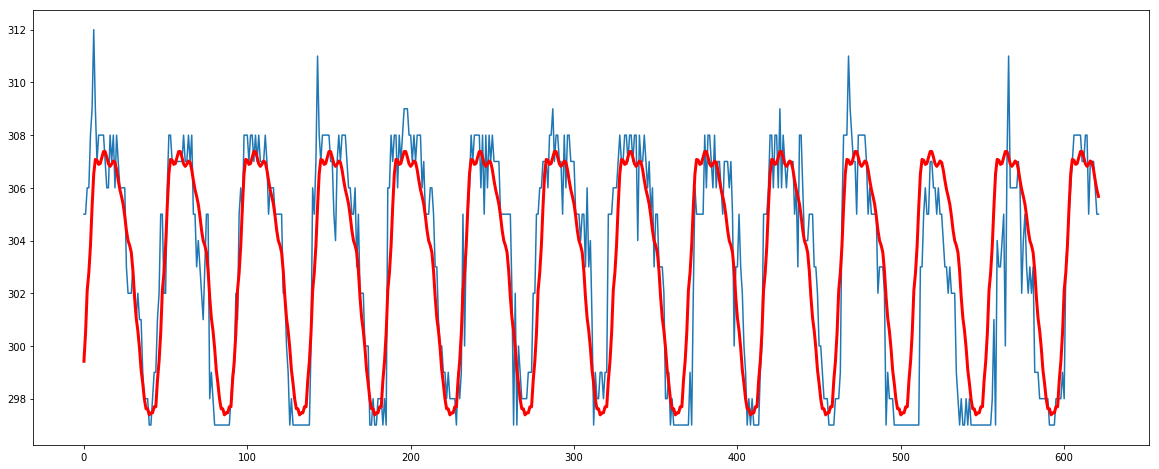

In [20]:
X = [i%46 for i in range(0, len(data_2))]
y = data_2[:, 0, 1]
degree = 100
coef1 = polyfit(X, y, degree)
print('Coefficients: %s' % coef1)
# create curve
curve1 = list()
for i in range(len(X)):
    value = coef1[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef1[d]
    curve1.append(value)
    
# plot curve over original data
plt.plot(y)
plt.plot(curve1, color='red', linewidth=3)
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.


Coefficients: [-2.38871722e-73  2.31865425e-71  1.21082545e-70 -3.06204564e-68
 -1.39812907e-66 -1.39454253e-65  1.78464481e-63  1.29371014e-61
  4.46338983e-60  3.01625513e-59 -6.82781311e-57 -5.09722784e-55
 -2.03437556e-53 -3.41228059e-52  1.82788058e-50  1.94728228e-48
  9.54311842e-47  2.48479031e-45 -2.94285501e-44 -7.20245400e-42
 -4.24318258e-40 -1.31962864e-38  2.56296312e-38  2.97788841e-35
  1.86269646e-33  5.37912602e-32 -6.90393368e-31 -1.57928258e-28
 -7.70008307e-27 -8.69294233e-26  1.22276165e-23  8.08401303e-22
  1.08904748e-20 -1.33170020e-18 -7.47547959e-17  6.04983198e-16
  1.84165169e-13  1.60815318e-12 -4.13448061e-10 -4.94271622e-10
  9.75369094e-07 -4.44093153e-05  1.05616349e-03 -1.57770966e-02
  1.55373592e-01 -1.00905997e+00  4.18270841e+00 -1.03173919e+01
  1.32084876e+01 -5.16929509e+00  2.99424576e+02]


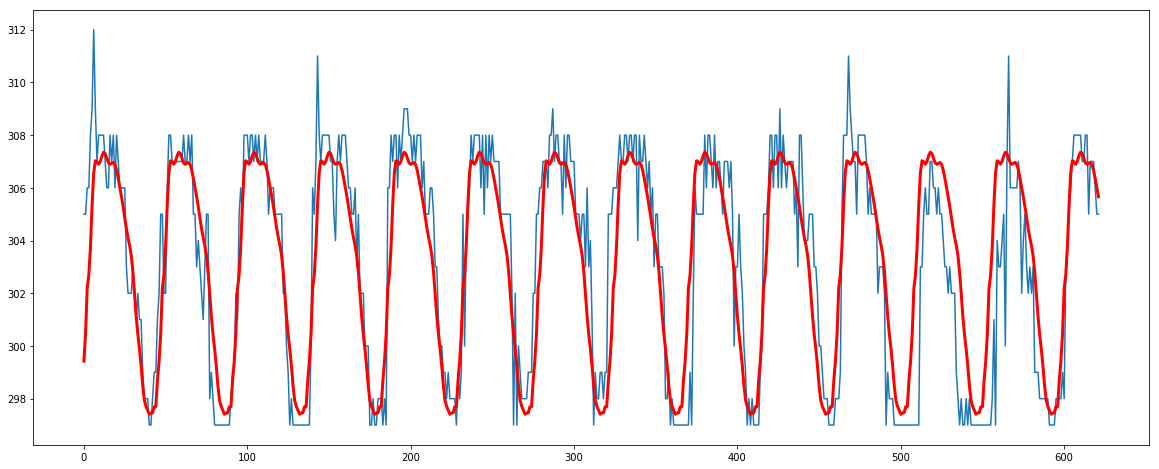

In [21]:
X = [i%46 for i in range(0, len(data_2))]
y = data_2[:, 0, 1]
degree = 50
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
    
# plot curve over original data
plt.plot(y)
plt.plot(curve, color='red', linewidth=3)
plt.show()

In [22]:
import statsmodels.api as sm
import itertools

In [23]:
y = data_2[:-92, 0, 1]

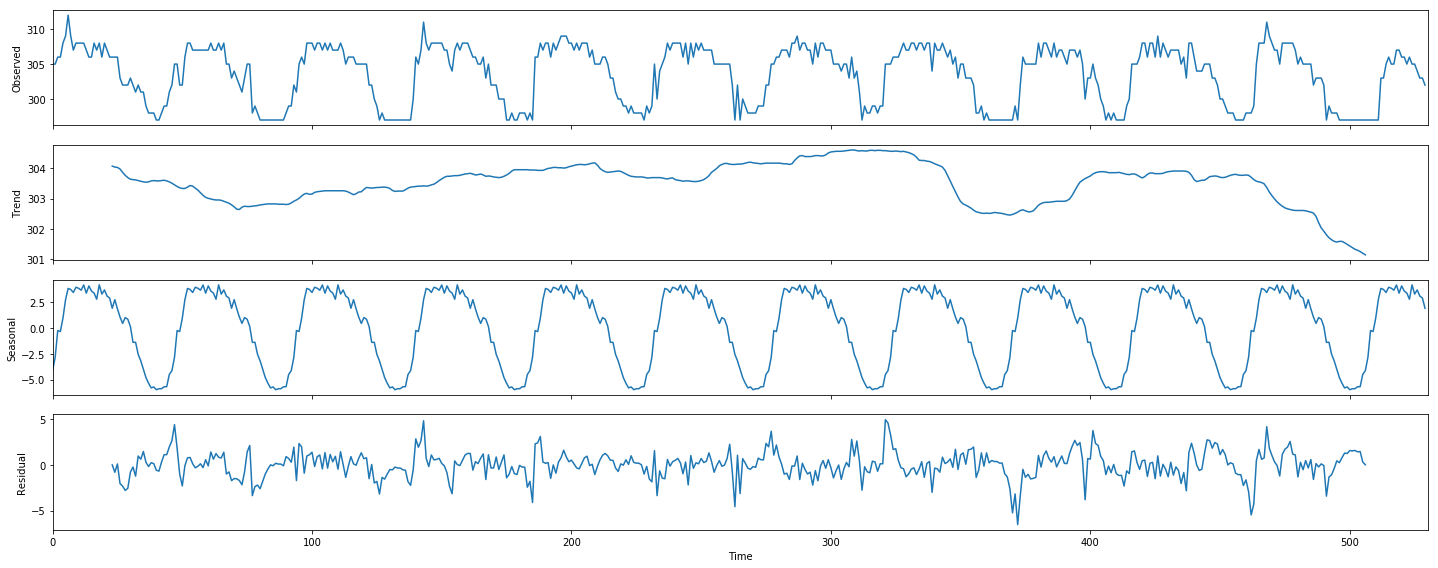

In [24]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive', freq=46)
fig = decomposition.plot()
plt.show()

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

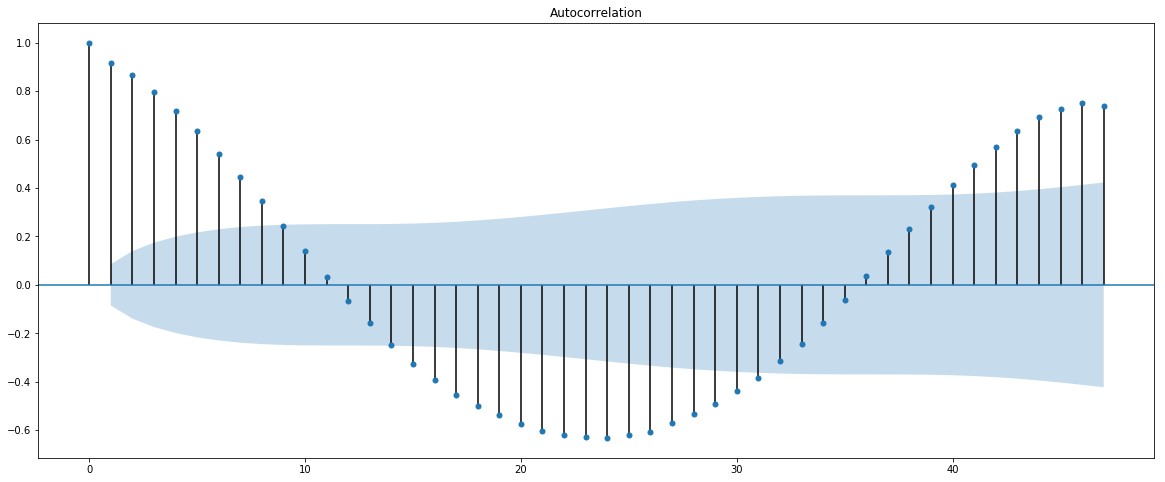

In [26]:
plot_acf(y, lags=47)
plt.show()

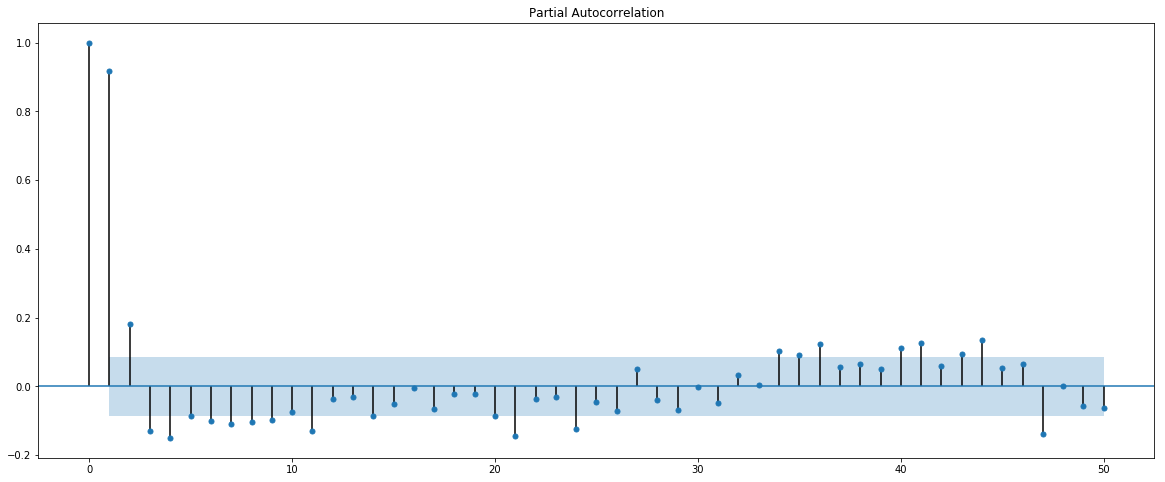

In [27]:
plot_pacf(y, lags=50)
plt.show()

In [28]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 46) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 46)
SARIMAX: (0, 0, 1) x (0, 0, 2, 46)
SARIMAX: (0, 0, 2) x (0, 1, 0, 46)
SARIMAX: (0, 0, 2) x (0, 1, 1, 46)


In [30]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 46)12 - AIC:8862.00845526189
ARIMA(0, 0, 0)x(0, 0, 1, 46)12 - AIC:7568.7986768664305
ARIMA(0, 0, 0)x(0, 1, 0, 46)12 - AIC:2650.3800047925542
ARIMA(0, 0, 0)x(0, 1, 1, 46)12 - AIC:2302.5897318913553
ARIMA(0, 0, 0)x(1, 0, 0, 46)12 - AIC:2655.745373641678
ARIMA(0, 0, 0)x(1, 0, 1, 46)12 - AIC:2489.5666261394063
ARIMA(0, 0, 0)x(1, 1, 0, 46)12 - AIC:2384.4559294716682
ARIMA(0, 0, 0)x(1, 1, 1, 46)12 - AIC:2304.504095887135
ARIMA(0, 0, 1)x(0, 0, 0, 46)12 - AIC:8004.201489056448
ARIMA(0, 0, 1)x(0, 0, 1, 46)12 - AIC:6778.556199794619
ARIMA(0, 0, 1)x(0, 1, 0, 46)12 - AIC:2495.000153086993
ARIMA(0, 0, 1)x(0, 1, 1, 46)12 - AIC:2133.796944233355
ARIMA(0, 0, 1)x(1, 0, 0, 46)12 - AIC:2504.567938462562


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 46)12 - AIC:2681.3965324223063
ARIMA(0, 0, 1)x(1, 1, 0, 46)12 - AIC:2229.0018691232867
ARIMA(0, 0, 1)x(1, 1, 1, 46)12 - AIC:2135.7699925293136
ARIMA(0, 1, 0)x(0, 0, 0, 46)12 - AIC:2413.9714373926117
ARIMA(0, 1, 0)x(0, 0, 1, 46)12 - AIC:2241.8380914005593
ARIMA(0, 1, 0)x(0, 1, 0, 46)12 - AIC:2542.4272793786686
ARIMA(0, 1, 0)x(0, 1, 1, 46)12 - AIC:2094.85472926478
ARIMA(0, 1, 0)x(1, 0, 0, 46)12 - AIC:2242.3251339763765
ARIMA(0, 1, 0)x(1, 0, 1, 46)12 - AIC:2232.8188179125373
ARIMA(0, 1, 0)x(1, 1, 0, 46)12 - AIC:2213.332534715017
ARIMA(0, 1, 0)x(1, 1, 1, 46)12 - AIC:2096.8546128003823
ARIMA(0, 1, 1)x(0, 0, 0, 46)12 - AIC:2385.627250991736
ARIMA(0, 1, 1)x(0, 0, 1, 46)12 - AIC:2203.622059411142
ARIMA(0, 1, 1)x(0, 1, 0, 46)12 - AIC:2415.7277194869826
ARIMA(0, 1, 1)x(0, 1, 1, 46)12 - AIC:1996.8723595237866
ARIMA(0, 1, 1)x(1, 0, 0, 46)12 - AIC:2197.208846891834
ARIMA(0, 1, 1)x(1, 0, 1, 46)12 - AIC:2151.9941011175624
ARIMA(0, 1, 1)x(1, 1, 0, 46)12 - AIC:2107.210764699398

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 46)12 - AIC:2266.0738390037754
ARIMA(1, 0, 0)x(0, 1, 0, 46)12 - AIC:2414.29441030653
ARIMA(1, 0, 0)x(0, 1, 1, 46)12 - AIC:2007.772713182915
ARIMA(1, 0, 0)x(1, 0, 0, 46)12 - AIC:2244.325442122461
ARIMA(1, 0, 0)x(1, 0, 1, 46)12 - AIC:2240.645936253542
ARIMA(1, 0, 0)x(1, 1, 0, 46)12 - AIC:2109.3502323712337
ARIMA(1, 0, 0)x(1, 1, 1, 46)12 - AIC:2009.7681047631131
ARIMA(1, 0, 1)x(0, 0, 0, 46)12 - AIC:2391.458374791532


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 46)12 - AIC:2243.9179902269498
ARIMA(1, 0, 1)x(0, 1, 0, 46)12 - AIC:2382.073302785754
ARIMA(1, 0, 1)x(0, 1, 1, 46)12 - AIC:1969.6409511186248
ARIMA(1, 0, 1)x(1, 0, 0, 46)12 - AIC:2199.2095306557935
ARIMA(1, 0, 1)x(1, 0, 1, 46)12 - AIC:2157.465898867884
ARIMA(1, 0, 1)x(1, 1, 0, 46)12 - AIC:2074.2133032633956
ARIMA(1, 0, 1)x(1, 1, 1, 46)12 - AIC:1971.606729809332
ARIMA(1, 1, 0)x(0, 0, 0, 46)12 - AIC:2383.860766383111
ARIMA(1, 1, 0)x(0, 0, 1, 46)12 - AIC:2202.474258774894
ARIMA(1, 1, 0)x(0, 1, 0, 46)12 - AIC:2460.4888101870074
ARIMA(1, 1, 0)x(0, 1, 1, 46)12 - AIC:2022.1449540824551
ARIMA(1, 1, 0)x(1, 0, 0, 46)12 - AIC:2190.4921011454644
ARIMA(1, 1, 0)x(1, 0, 1, 46)12 - AIC:2168.417636836374
ARIMA(1, 1, 0)x(1, 1, 0, 46)12 - AIC:2124.6412447213906
ARIMA(1, 1, 0)x(1, 1, 1, 46)12 - AIC:2024.1449972335595
ARIMA(1, 1, 1)x(0, 0, 0, 46)12 - AIC:2381.981218878812
ARIMA(1, 1, 1)x(0, 0, 1, 46)12 - AIC:2202.0947989230044
ARIMA(1, 1, 1)x(0, 1, 0, 46)12 - AIC:2393.728380713189


In [28]:
from time import time

In [48]:
data_3 = data_1[:-92, 0, 1]

In [49]:
start_time = time()
mod = sm.tsa.statespace.SARIMAX(data_3,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 46),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
end_time = time()
print('Running time = {:0.1f}s'.format(end_time - start_time))
print(results.summary().tables[1])

Running time = 4.2s
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8283      0.039     21.099      0.000       0.751       0.905
ma.L1         -0.5646      0.050    -11.185      0.000      -0.663      -0.466
ar.S.L46      -0.4788      0.007    -71.520      0.000      -0.492      -0.466
sigma2        10.1141      0.084    120.443      0.000       9.950      10.279


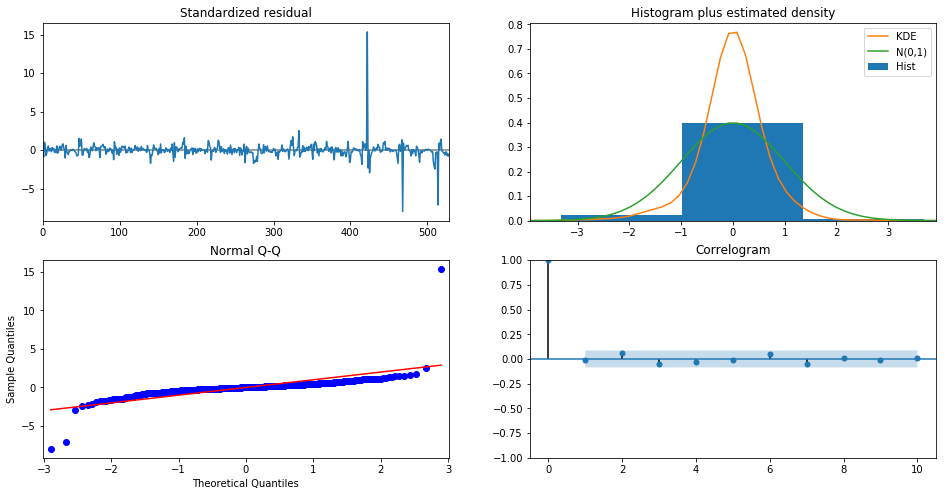

In [50]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [51]:
n = len(data_3)
n

622

In [52]:
pred = results.forecast(92)

In [53]:
gtruth = data_1[-92:, 0, 1]

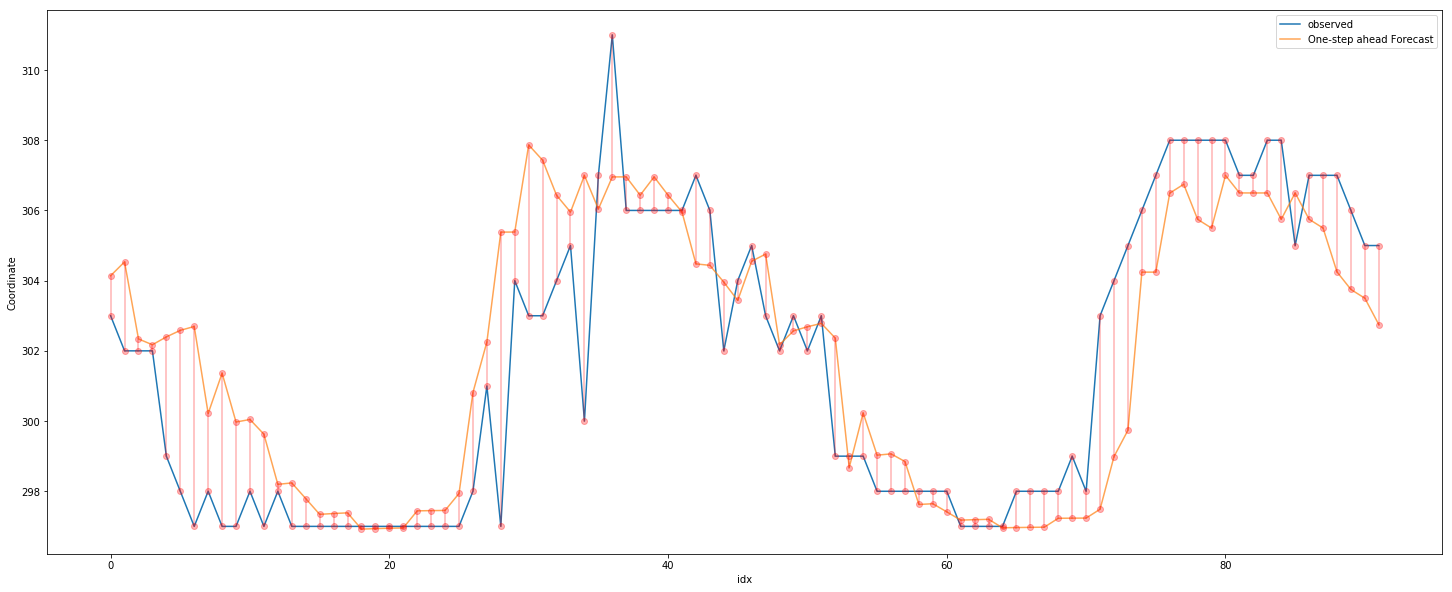

In [54]:
fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.plot(gtruth, label='observed')
ax.plot(pred, label='One-step ahead Forecast', alpha=.7)

y1 = np.concatenate([gtruth.reshape(-1, 1), pred.reshape(-1, 1)], axis=-1)
for i in range(0, len(y1)):
    plt.plot([i, i], y1[i], 'ro-', alpha=0.3)

ax.set_xlabel('idx')
ax.set_ylabel('Coordinate')
plt.legend()
plt.show()

In [55]:
np.mean((gtruth - pred)**2)

5.499670165695856

In [134]:
y = data_2[:-92, 0, 1]
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 46),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

ypred = []
y1 = y.copy().reshape(-1, 1)
for i in range(len(gtruth)):
    yhat = results.forecast(1)[0]
    ypred.append(yhat)
    ytrue = gtruth[i: i+1].reshape(-1, 1)
    y1 = np.vstack([y1, ytrue])
    mod = sm.tsa.statespace.SARIMAX(y1,
                                    order=(1, 0, 1),
                                    seasonal_order=(1, 1, 0, 46),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8158      0.037     22.095      0.000       0.743       0.888
ma.L1         -0.3242      0.062     -5.196      0.000      -0.446      -0.202
ar.S.L46      -0.4592      0.033    -13.767      0.000      -0.525      -0.394
sigma2         2.7594      0.135     20.509      0.000       2.496       3.023


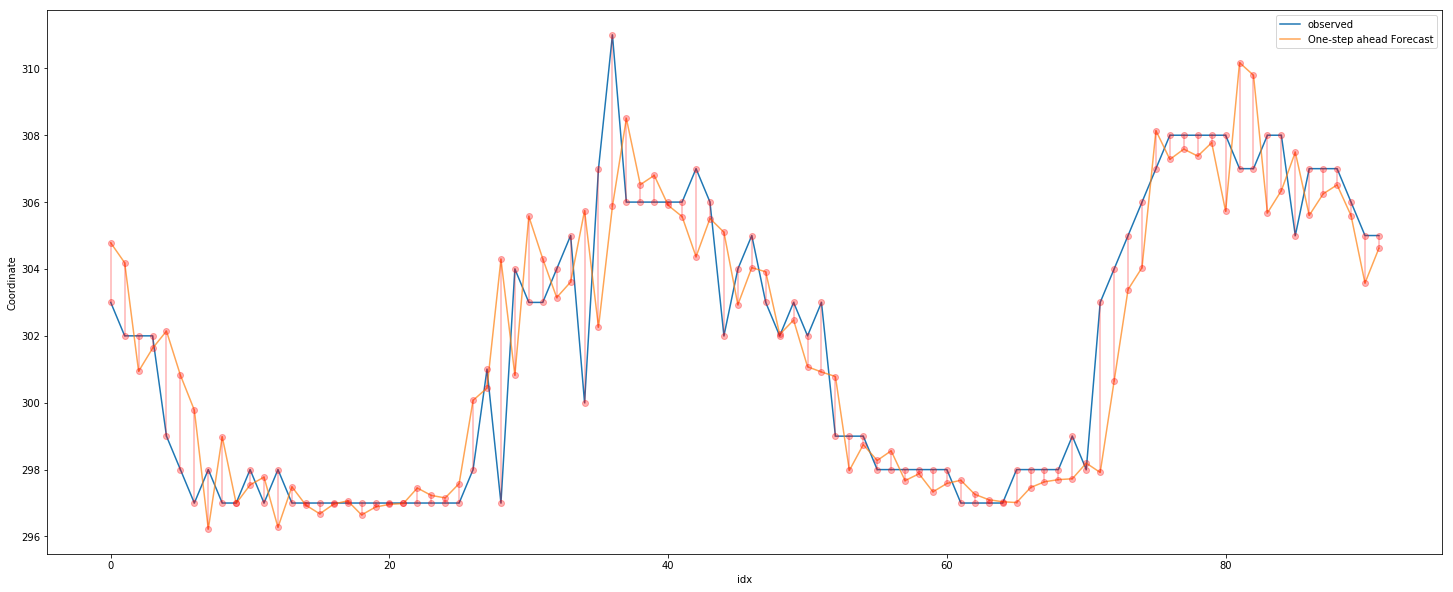

In [135]:
ypred = np.asarray(ypred)

fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.plot(gtruth, label='observed')
ax.plot(ypred, label='One-step ahead Forecast', alpha=.7)

y1 = np.concatenate([gtruth.reshape(-1, 1), ypred.reshape(-1, 1)], axis=-1)
for i in range(0, len(y1)):
    plt.plot([i, i], y1[i], 'ro-', alpha=0.3)

ax.set_xlabel('idx')
ax.set_ylabel('Coordinate')
plt.legend()
plt.show()

In [136]:
np.mean((gtruth - ypred)**2)

3.668518770967984

In [146]:
data_2.shape

(622, 1024, 2)

In [147]:
data = data_2.reshape(data_2.shape[0], -1)
data.shape

(622, 2048)

In [149]:
data_train = data[:-n_tests]

In [150]:
data_train.shape

(530, 2048)

In [148]:
# VARMA example
n_tests = 92
from statsmodels.tsa.statespace.varmax import VARMAX
data = data_2.reshape(data_2.shape[0], -1)
data_train = data[:-n_tests]
print(data_train.shape)
# fit model
model = VARMAX(data_train, order=(1, 1))
model_fit = model.fit(disp=False)

# make prediction
yhat = model_fit.forecast(n_tests)
ytrue = data[n_tests:, -1]
print(np.mean((yhat - ytrue)**2))

(530, 2048)


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


ValueError: x already contains a constant

In [157]:
import pandas as pd

In [159]:
data = data_2.reshape(data_2.shape[0], -1)
data.shape

(622, 2048)

In [160]:
df = pd.DataFrame(data=data)

In [161]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,256.0,305.0,256.0,305.0,257.0,307.0,257.0,307.0,257.0,306.0,...,255.0,303.0,255.0,303.0,255.0,306.0,255.0,306.0,255.0,306.0
1,256.0,305.0,256.0,305.0,257.0,307.0,257.0,307.0,257.0,306.0,...,254.0,305.0,255.0,305.0,255.0,306.0,255.0,306.0,255.0,306.0
2,256.0,306.0,256.0,306.0,257.0,308.0,257.0,308.0,257.0,306.0,...,254.0,306.0,255.0,305.0,255.0,307.0,255.0,307.0,255.0,307.0
3,256.0,306.0,256.0,306.0,257.0,310.0,257.0,310.0,257.0,307.0,...,254.0,306.0,255.0,305.0,255.0,306.0,255.0,306.0,255.0,306.0
4,256.0,308.0,256.0,308.0,257.0,311.0,257.0,310.0,257.0,309.0,...,254.0,308.0,255.0,307.0,255.0,308.0,255.0,308.0,255.0,308.0


In [162]:
df.shape

(622, 2048)

In [163]:
df1 = df.loc[:, (df != df.iloc[0]).any()]

In [164]:
df1.shape

(622, 2021)

In [165]:
df1.head()

,1,3,5,7,8,9,10,11,12,13,...,2035,2036,2037,2038,2039,2040,2041,2043,2045,2047
0,305.0,305.0,307.0,307.0,257.0,306.0,258.0,309.0,258.0,309.0,...,303.0,254.0,304.0,255.0,303.0,255.0,303.0,306.0,306.0,306.0
1,305.0,305.0,307.0,307.0,257.0,306.0,258.0,310.0,258.0,310.0,...,304.0,254.0,305.0,254.0,305.0,255.0,305.0,306.0,306.0,306.0
2,306.0,306.0,308.0,308.0,257.0,306.0,258.0,309.0,258.0,309.0,...,304.0,254.0,306.0,254.0,306.0,255.0,305.0,307.0,307.0,307.0
3,306.0,306.0,310.0,310.0,257.0,307.0,258.0,311.0,258.0,310.0,...,305.0,254.0,306.0,254.0,306.0,255.0,305.0,306.0,306.0,306.0
4,308.0,308.0,311.0,310.0,257.0,309.0,258.0,311.0,258.0,310.0,...,306.0,254.0,308.0,254.0,308.0,255.0,307.0,308.0,308.0,308.0


In [167]:
# VARMA example
n_tests = 92
from statsmodels.tsa.statespace.varmax import VARMAX
data_train = df1.iloc[:-n_tests]
print(data_train.shape)
# fit model
model = VARMAX(data_train, order=(1, 1),
               enforce_stationarity=False,
               enforce_invertibility=False)
model_fit = model.fit(disp=False)

# make prediction
yhat = model_fit.forecast(n_tests)
ytrue = df1[n_tests:, -1]
print(np.mean((yhat - ytrue)**2))

(530, 2021)


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


LinAlgError: Matrix is not positive definite

In [154]:
data1 = np.asarray(data)

In [155]:
data1.shape

(100, 2)

In [156]:
model = VARMAX(data1, order=(1, 1))
model_fit = model.fit(disp=False)

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [152]:
# VARMA example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VARMAX(data, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast()
print(yhat)

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


[[0.52569645 1.03476983]]


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

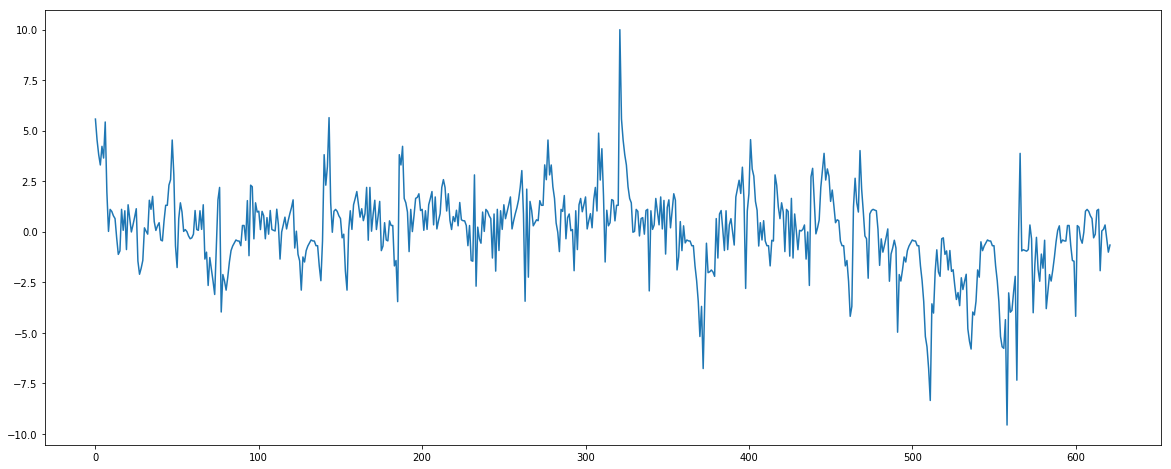

In [0]:

diff_train_1 = list()
for i in range(len(y)):
    value = y[i] - curve[i]
    diff_train_1.append(value)
    
diff_train_1[np.argmax(diff_train_1)] = 10
plt.plot(diff_train_1)
plt.show()

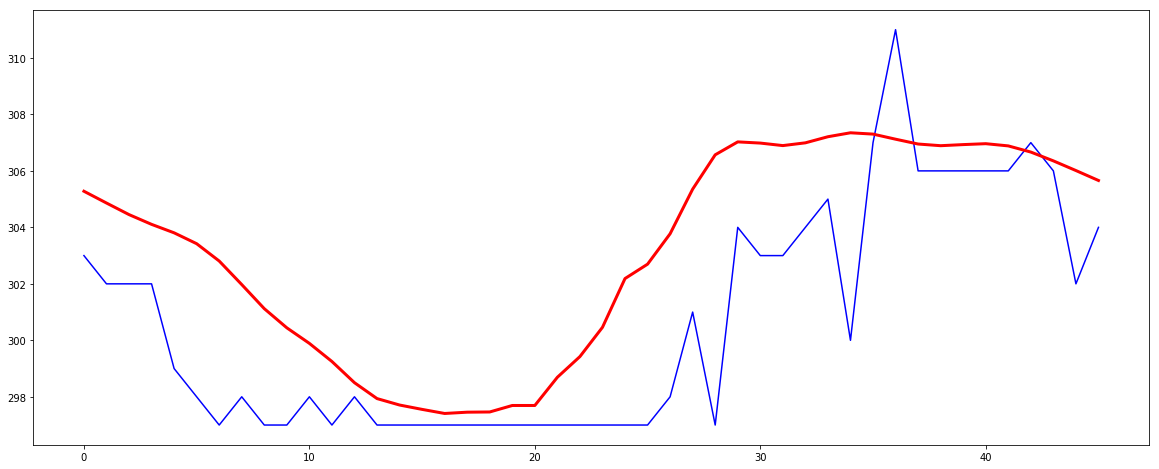

In [0]:
plt.plot(val_boundary_vectors[:, 0, 1], color='b')
plt.plot(curve[24:24 + 46], color='red', linewidth=3)
plt.show()

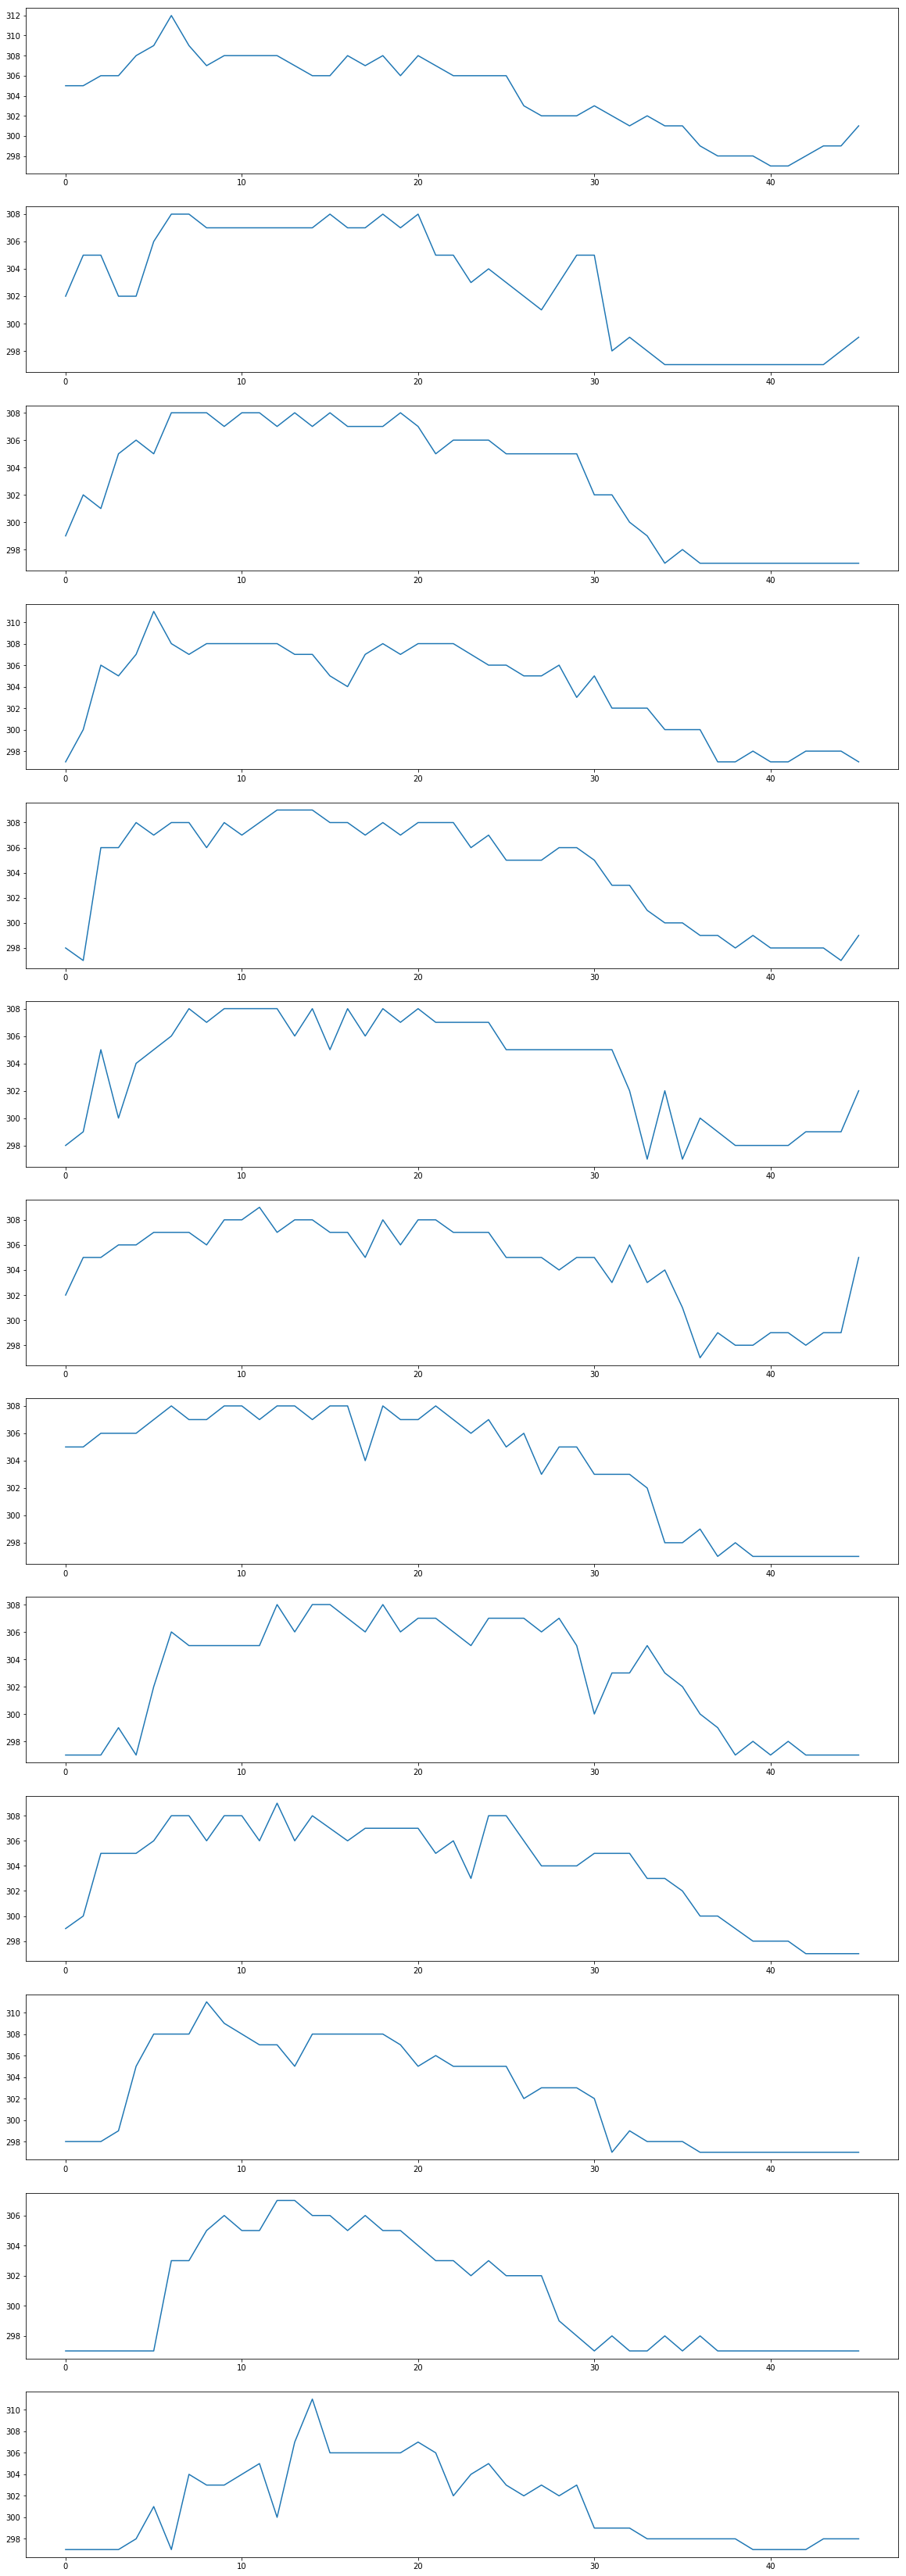

In [0]:
n_years = len(data_2)//46
fig, axes = plt.subplots(n_years, 1, figsize=(20,60))
for i in range(n_years):
    axes[i].plot(data_2[i*46 : (i + 1)*46, 1, 1])

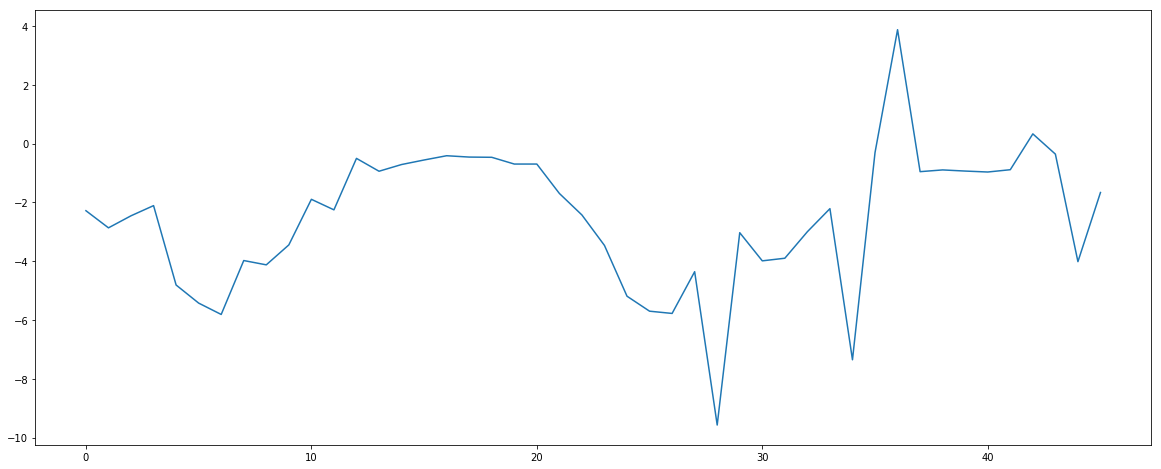

In [0]:
diff_val_1 = list()
for i in range(len(val_boundary_vectors)):
    value = val_boundary_vectors[i, 0, 1] - curve[i + 24]
    diff_val_1.append(value)
plt.plot(diff_val_1)
plt.show()

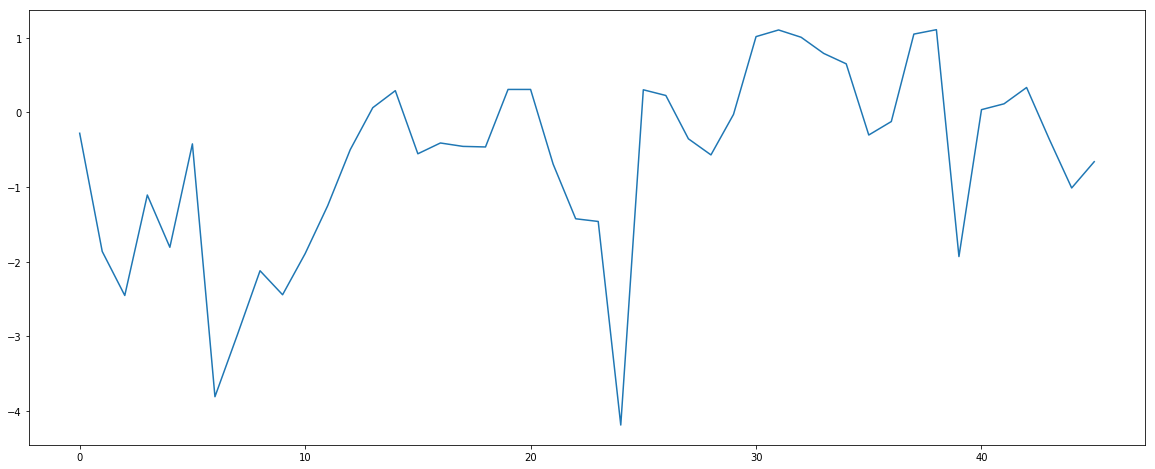

In [0]:
diff_test_1 = list()
for i in range(len(test_boundary_vectors)):
    value = test_boundary_vectors[i, 0, 1] - curve[i + 24]
    diff_test_1.append(value)
plt.plot(diff_test_1)
plt.show()

In [0]:
diff_train_1 = np.asarray(diff_train_1).reshape(-1, 1).reshape(-1, 1)
diff_val_1 = np.asarray(diff_val_1).reshape(-1, 1).reshape(-1, 1)
diff_test_1 = np.asarray(diff_test_1).reshape(-1, 1).reshape(-1, 1)

In [0]:
diff_train_1.shape, diff_val_1.shape, diff_test_1.shape

((622, 1), (46, 1), (46, 1))

In [0]:
timesteps = 50
train_X, train_Y = create_dataset(diff_train_1, timesteps)
val_X, val_Y = create_dataset(np.concatenate(
    [diff_train_1[-timesteps:], diff_val_1]), timesteps)
test_X, test_Y = create_dataset(np.concatenate(
    [diff_train_1[-4:], diff_val_1[-timesteps:], diff_test_1]), timesteps)

In [0]:
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape

((572, 50, 1), (572, 1), (46, 50, 1), (46, 1), (46, 50, 1), (46, 1))

In [0]:
def create_model(timesteps, ndims, learning_rate=0.001):
    inputs = Input(shape=(timesteps, ndims))
    x = LSTM(ndims*2, return_sequences=True, activation='tanh')(inputs)
    x = LSTM(ndims*8, return_sequences=True, activation='tanh')(x)
    x = LSTM(ndims*2, return_sequences=True, activation='tanh')(x)
    '''
    x = LSTM(ndims*4, return_sequences=True, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = LSTM(ndims*2, return_sequences=True, activation='tanh')(x)
    x = BatchNormalization()(x)
    '''
    predict = LSTM(ndims, return_sequences=False)(x)
    model = Model(inputs=inputs, outputs=predict)
    model.compile(loss='mse', optimizer=adam(lr=learning_rate))
    return model

In [0]:
model = create_model(timesteps, 1, 0.01)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 50, 1)             0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50, 2)             32        
_________________________________________________________________
lstm_27 (LSTM)               (None, 50, 8)             352       
_________________________________________________________________
lstm_28 (LSTM)               (None, 50, 2)             88        
_________________________________________________________________
lstm_29 (LSTM)               (None, 1)                 16        
Total params: 488
Trainable params: 488
Non-trainable params: 0
_________________________________________________________________


In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001, verbose=1)

In [0]:
model.fit(train_X, train_Y, epochs=30, batch_size=8, validation_data=(val_X, val_Y), callbacks=[reduce_lr])

Train on 572 samples, validate on 46 samples
Epoch 1/30
572/572 [==============================] - 26s 45ms/step - loss: 4.0457 - val_loss: 10.2313
Epoch 2/30
572/572 [==============================] - 20s 34ms/step - loss: 3.8519 - val_loss: 9.7580
Epoch 3/30
572/572 [==============================] - 21s 36ms/step - loss: 3.6738 - val_loss: 8.9129
Epoch 4/30
572/572 [==============================] - 20s 34ms/step - loss: 3.4585 - val_loss: 8.3902
Epoch 5/30
572/572 [==============================] - 20s 34ms/step - loss: 3.2432 - val_loss: 8.4510
Epoch 6/30
572/572 [==============================] - 19s 34ms/step - loss: 3.0072 - val_loss: 8.3649
Epoch 7/30
572/572 [==============================] - 20s 36ms/step - loss: 2.9426 - val_loss: 8.3935
Epoch 8/30
572/572 [==============================] - 19s 33ms/step - loss: 2.9216 - val_loss: 8.3842
Epoch 9/30
572/572 [==============================] - 19s 34ms/step - loss: 2.8835 - val_loss: 8.4013
Epoch 10/30
572/572 [===============

In [0]:
diff_train_Y_hat = model.predict(train_X[-46:])

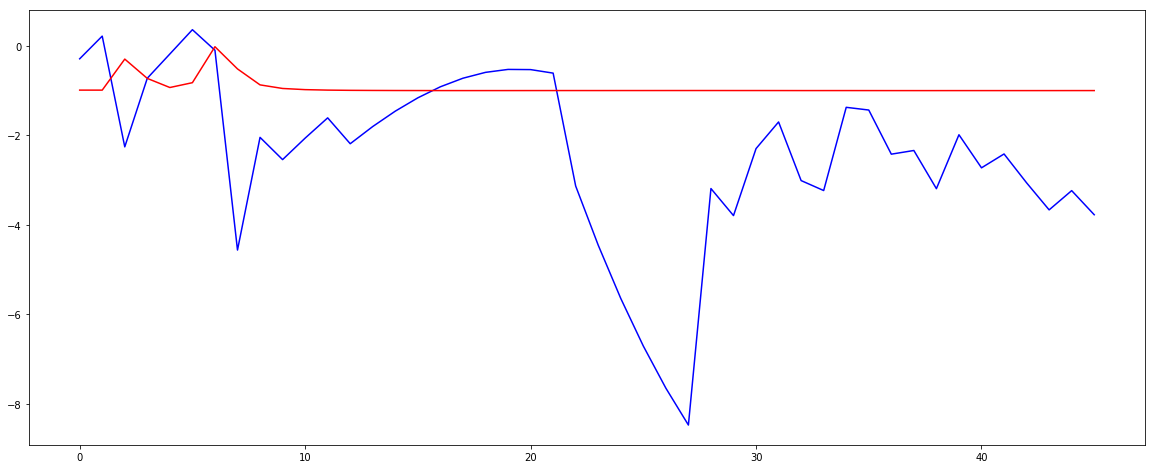

In [0]:
plt.plot(train_Y[-46:], color='b')
plt.plot(diff_train_Y_hat, color='r')

In [0]:
diff_val_Y_hat = model.predict(val_X)

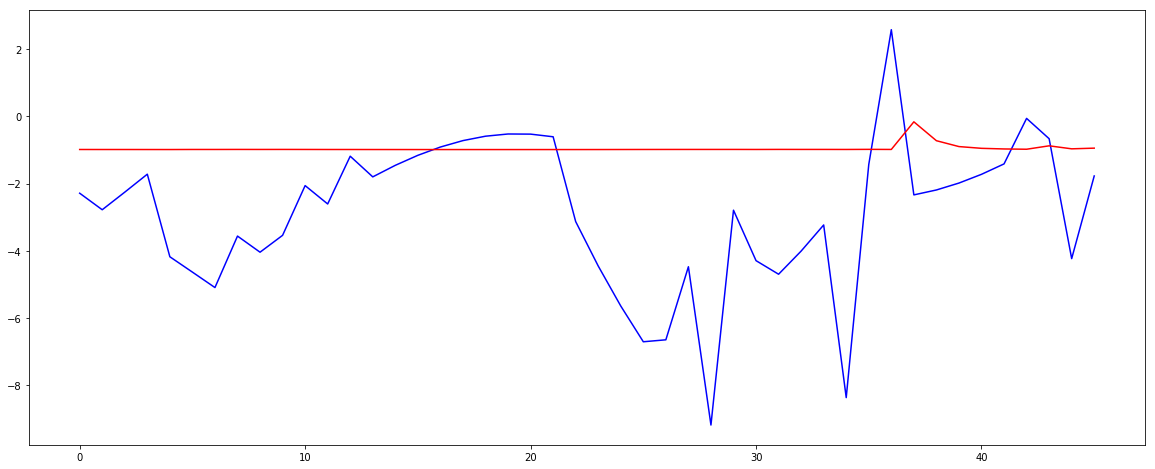

In [0]:
plt.plot(val_Y, color='b')
plt.plot(diff_val_Y_hat, color='r')

In [0]:
scaler_diff_1 = MinMaxScaler(feature_range=(0, 1))
scaler_diff_1.fit(diff_train_1.reshape(diff_train_1.shape[0], -1))

def transform(data, scaler):
    old_shape = data.shape
    data = data.reshape(old_shape[0], -1)
    if scaler is not None:
        data = scaler.transform(data.astype(np.float))
    return data.reshape(old_shape)

In [0]:
diff_train_2 = transform(diff_train_1, scaler_diff_1)
diff_val_2 = transform(diff_val_1, scaler_diff_1)
diff_test_2 = transform(diff_test_1, scaler_diff_1)

In [0]:
diff_train_2.shape, diff_val_2.shape, diff_test_2.shape

((622, 1), (46, 1), (46, 1))

In [0]:
timesteps = 8
train_X, train_Y = create_dataset(diff_train_2, timesteps)
val_X, val_Y = create_dataset(np.concatenate(
    [diff_train_2[-timesteps:], diff_val_2]), timesteps)

if timesteps > len(diff_val_2):
    test_X, test_Y = create_dataset(np.concatenate(
        [diff_train_2[len(diff_val_2) - timesteps:], diff_val_2[-timesteps:], diff_test_2]), timesteps)
else:
    test_X, test_Y = create_dataset(np.concatenate(
        [diff_val_2[-timesteps:], diff_test_2]), timesteps)

In [0]:
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape

((614, 8, 1), (614, 1), (46, 8, 1), (46, 1), (46, 8, 1), (46, 1))

In [0]:
model = create_model(timesteps, 1, 0.01)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8, 1)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 8, 2)              32        
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 2)              8         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1)                 16        
Total params: 56
Trainable params: 52
Non-trainable params: 4
_________________________________________________________________


In [0]:
model.fit(train_X, train_Y, epochs=30, batch_size=8, validation_data=(val_X, val_Y), callbacks=[reduce_lr])

Train on 614 samples, validate on 46 samples
Epoch 1/30
614/614 [==============================] - 8s 13ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 2/30
614/614 [==============================] - 4s 6ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 3/30
614/614 [==============================] - 4s 6ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 4/30
614/614 [==============================] - 4s 6ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 5/30
614/614 [==============================] - 4s 6ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 6/30
614/614 [==============================] - 4s 6ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 7/30
614/614 [==============================] - 4s 6ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 8/30
614/614 [==============================] - 4s 6ms/step - loss: 0.0024 - val_loss: 0.0029

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 9/30
614/614 [==============================] - 4s 6ms/step - loss:

In [0]:
diff_val_Y_hat = model.predict(val_X)

In [0]:
diff_val_Y_hat.shape

(46, 1)

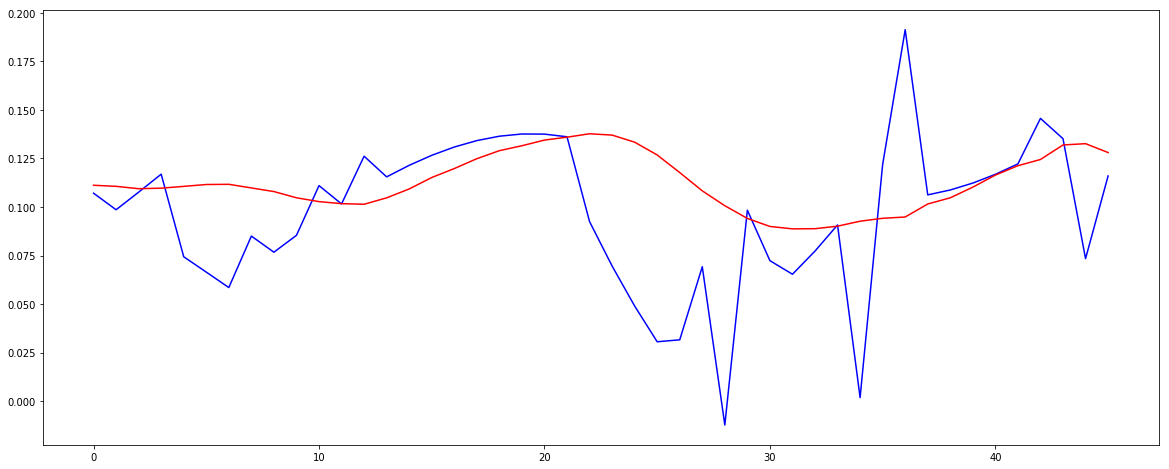

In [0]:
plt.plot(val_Y, color='b')
plt.plot(diff_val_Y_hat, color='r')

In [0]:
diff_test_Y_hat = model.predict(test_X)

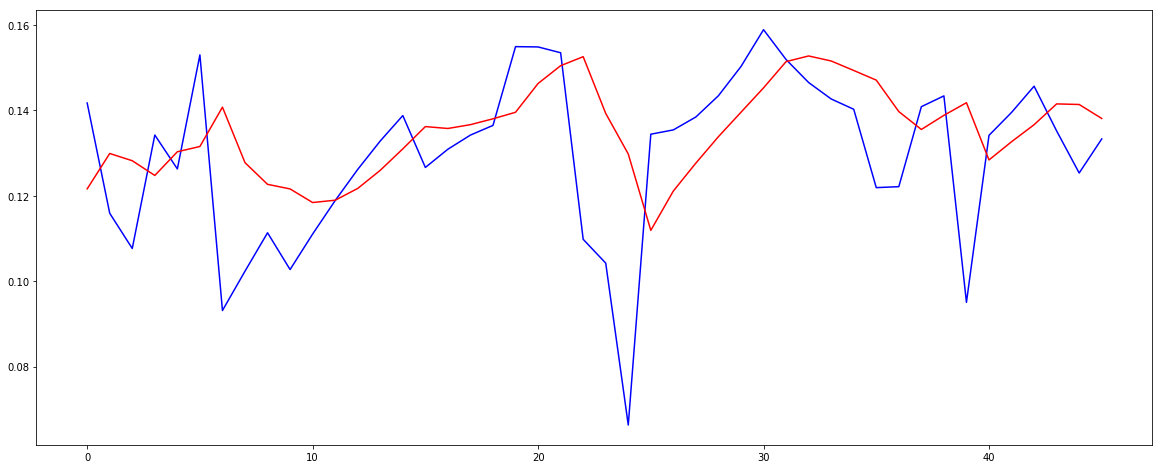

In [0]:
plt.plot(test_Y, color='b')
plt.plot(diff_test_Y_hat, color='r')

In [0]:
timesteps = 25
train_X, train_Y = create_dataset(train_boundary_vectors_1, timesteps)
val_X, val_Y = create_dataset(np.concatenate(
    [train_boundary_vectors_1[-timesteps:], val_boundary_vectors_1]),
                              timesteps)
test_X, test_Y = create_dataset(np.concatenate(
    [val_boundary_vectors_1[-timesteps:], test_boundary_vectors_1]),
                                timesteps)

In [0]:
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape

((388, 50, 1024, 2),
 (388, 1024, 2),
 (138, 50, 1024, 2),
 (138, 1024, 2),
 (138, 50, 1024, 2),
 (138, 1024, 2))

In [0]:
train_X.min(), train_X.max(), train_Y.min(), train_Y.max()

(-20.904544960367023,
 20.90454496036638,
 -20.904544960366973,
 20.90454496036638)

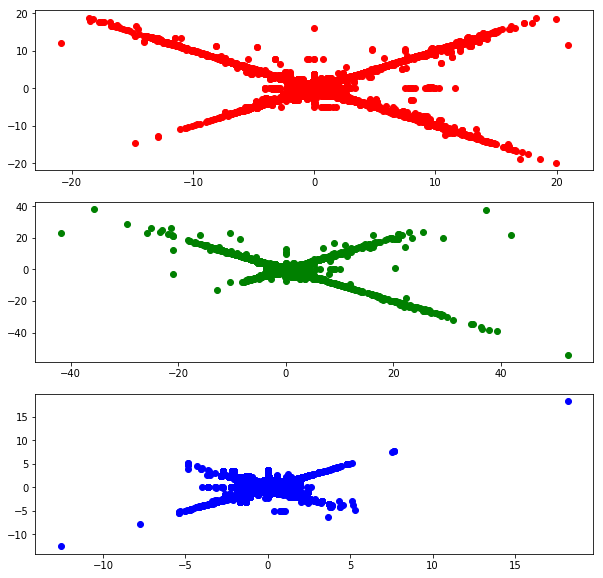

In [0]:
a = train_Y.reshape(-1, 2)
b = val_Y.reshape(-1, 2)
c = test_Y.reshape(-1, 2)

fig, ax = plt.subplots(3, 1, figsize=(10,10))
ax[0].scatter(a[:,0], a[:,1], color='r', label='train')
ax[1].scatter(b[:,0], b[:,1], color='g', label='val')
ax[2].scatter(c[:,0], c[:,1], color='b', label='test')

plt.show()

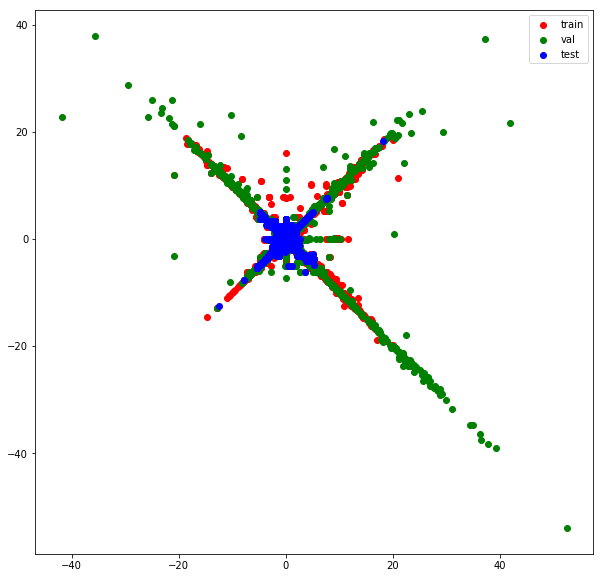

In [0]:
a = train_Y.reshape(-1, 2)
b = val_Y.reshape(-1, 2)
c = test_Y.reshape(-1, 2)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(a[:,0], a[:,1], color='r', label='train')
ax.scatter(b[:,0], b[:,1], color='g', label='val')
ax.scatter(c[:,0], c[:,1], color='b', label='test')

ax.legend()

plt.show()

In [0]:
def split_data(data, axis=0, n=4):
    data_split = []
    n_data_in_one_part = data.shape[axis]//n
    out_shape = list(data.shape)
    out_shape[axis] = n_data_in_one_part
    out_shape[0] = out_shape[0]*n
    data = data.reshape(-1, data.shape[axis])
    for i in range(n):
        data_split.append(data[:, n_data_in_one_part*i : n_data_in_one_part*(i+1)])
    data_split = np.vstack(data_split)
    data_split = data_split.reshape(out_shape)
    return data_split

In [0]:
n_split = 1
a = split_data(train_X, axis=2, n=n_split)
a.shape

(388, 50, 1024, 2)

In [0]:
train_X = split_data(train_X, axis=2, n=n_split)
train_Y = split_data(train_Y, axis=1, n=n_split)

val_X = split_data(val_X, axis=2, n=n_split)
val_Y = split_data(val_Y, axis=1, n=n_split)

test_X = split_data(test_X, axis=2, n=n_split)
test_Y = split_data(test_Y, axis=1, n=n_split)

print(train_X.shape, train_Y.shape, val_X.shape, val_Y.shape, test_X.shape, test_Y.shape)

(388, 50, 1024, 2) (388, 1024, 2) (138, 50, 1024, 2) (138, 1024, 2) (138, 50, 1024, 2) (138, 1024, 2)


In [0]:
def plot_model_(model):
    plot_model(model, to_file='model.png', show_shapes=True)
    model_plot = misc.imread('model.png')
    plt.imshow(model_plot)

In [0]:
def create_graph_matrix(n_points_on_boundary):
    def calc_arc_distance(a, b, n):
        diff = np.abs(a-b)
        if diff > n//2:
            diff = n - diff
        return diff
    
    n = n_points_on_boundary
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            mat[i,j] = calc_arc_distance(i, j, n)
    return mat.astype(np.float32)

def create_graph_matrix_1(n_points_on_boundary):
    def calc_arc_distance(a, b, n):
        diff = np.abs(a-b)
        if diff > n//2:
            diff = n - diff
        return diff
    
    n = n_points_on_boundary
    mat = np.zeros((2*n, 2*n))
    for i in range(n):
        for j in range(n):
            mat[i,j] = calc_arc_distance(i, j, n)
    mat[n:2*n, n:2*n] = mat[:n, :n]
    for i in range(n):
        for j in range(n, 2*n):
            mat[i,j] = mat[i, j - n]
    mat[n:2*n, :n] = mat[:n, n:2*n]
    return mat.astype(np.float32)

In [0]:
a = create_graph_matrix_1(n_points)
A = create_graph_matrix(n_points)
a.shape, A.shape

((2048, 2048), (1024, 1024))

In [0]:
import sys
sys.path.append(gdrive_dir)
#from grnn_keras import GRNN

In [0]:
def create_model(timesteps, ndims):
    inputs = Input(shape=(timesteps, ndims))
    x = LSTM(ndims*2, return_sequences=True, activation='tanh')(inputs)
    x = BatchNormalization()(x)
    x = LSTM(ndims*4, return_sequences=True, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = LSTM(ndims*2, return_sequences=True, activation='tanh')(x)
    x = BatchNormalization()(x)
    predict = LSTM(ndims, return_sequences=False)(x)
    model = Model(inputs=inputs, outputs=predict)
    model.compile(loss='mse', optimizer=adam(lr=0.001))
    return model
    
def create_model_1(timesteps, ndims):
    inputs = Input(shape=(timesteps, ndims))
    x = GRU(ndims*2, return_sequences=True, activation='tanh')(inputs)
    x = GRU(ndims*2, return_sequences=True, activation='tanh')(x)
    x = GRU(ndims*2, return_sequences=True, activation='tanh')(x)
    predict = GRU(ndims, return_sequences=False)(x)
    model = Model(inputs=inputs, outputs=predict)
    model.compile(loss='mse', optimizer=adam(lr=0.001))
    return model

'''
def create_model(timesteps, n_points, mat=None):
    if mat is None:
        mat = create_graph_matrix(n_points)
    if len(mat.shape) == 2:
        mat = np.expand_dims(mat, axis=0)
    
    model = Sequential()
    model.add(GraphConvLSTM_1(4, graph_conv_tensor=mat, return_sequences=True, activation='tanh',
                              input_shape=(timesteps, n_points, 2)))
    model.add(GraphConvLSTM_1(4, graph_conv_tensor=mat, return_sequences=True, activation='tanh'))
    model.add(GraphConvLSTM_1(2, graph_conv_tensor=mat, return_sequences=False, activation='sigmoid'))
    
    model.compile(loss=custom_loss_tf, optimizer=adam(lr=0.001))
    return model
'''

"\ndef create_model(timesteps, n_points, mat=None):\n    if mat is None:\n        mat = create_graph_matrix(n_points)\n    if len(mat.shape) == 2:\n        mat = np.expand_dims(mat, axis=0)\n    \n    model = Sequential()\n    model.add(GraphConvLSTM_1(4, graph_conv_tensor=mat, return_sequences=True, activation='tanh',\n                              input_shape=(timesteps, n_points, 2)))\n    model.add(GraphConvLSTM_1(4, graph_conv_tensor=mat, return_sequences=True, activation='tanh'))\n    model.add(GraphConvLSTM_1(2, graph_conv_tensor=mat, return_sequences=False, activation='sigmoid'))\n    \n    model.compile(loss=custom_loss_tf, optimizer=adam(lr=0.001))\n    return model\n"

In [0]:
'''
def create_model(timesteps, n_nodes, ndims, n_hiddens):
    K.clear_session()
    input_main = Input(shape=(timesteps, n_nodes, ndims))
    input_aux = Input(shape=(n_nodes, n_nodes), name='A')
    inputs = [input_main, input_aux]
    
    x = GRNN(n_nodes, ndims, return_sequences=False)(inputs)
    #x = GRNN(n_nodes, ndims)([x, input_aux])
    model = Model(inputs=inputs, outputs=x)
    model.compile(loss='mse', optimizer=adam(lr=0.001))
    return model
'''

"\ndef create_model(timesteps, n_nodes, ndims, n_hiddens):\n    K.clear_session()\n    input_main = Input(shape=(timesteps, n_nodes, ndims))\n    input_aux = Input(shape=(n_nodes, n_nodes), name='A')\n    inputs = [input_main, input_aux]\n    \n    x = GRNN(n_nodes, ndims, return_sequences=False)(inputs)\n    #x = GRNN(n_nodes, ndims)([x, input_aux])\n    model = Model(inputs=inputs, outputs=x)\n    model.compile(loss='mse', optimizer=adam(lr=0.001))\n    return model\n"

In [0]:
batch_size = 1
n_nodes = train_X.shape[-2]
#n_dims = train_X.shape[-1]
n_dims = 8
n_hidden = n_dims*2
model = create_model(timesteps, n_dims)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50, 8)             0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 50, 16)            1600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 16)            64        
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 32)            6272      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 32)            128       
_________________________________________________________________
lstm_23 (LSTM)               (None, 50, 16)            3136      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 16)            64        
__________

In [0]:
def get_data(data, ndims):
    if len(data.shape) == 4:
        data = data[:,:,:ndims//2,:]
        return data.reshape(data.shape[0], data.shape[1], -1)
    else:
        data = data[:,:ndims//2,:]
        return data.reshape(data.shape[0], -1)

In [0]:
#A128_1 = np.random.randn(388, n_nodes, n_nodes)
#X_128 = np.random.randn(388, 50, n_nodes, 2)
#Y_128 = np.random.randn(388, n_nodes, 2)

train_X_1 = get_data(train_X, n_dims)
train_Y_1 = get_data(train_Y, n_dims)
val_X_1 = get_data(val_X, n_dims)
val_Y_1 = get_data(val_Y, n_dims)

In [0]:
train_X_1.shape, train_Y_1.shape, val_X_1.shape, val_Y_1.shape

((388, 50, 8), (388, 8), (138, 50, 8), (138, 8))

In [0]:
history = model.fit(train_X_1, train_Y_1, epochs=20, batch_size=64, validation_data=(val_X_1, val_Y_1))

Train on 388 samples, validate on 138 samples
Epoch 1/20
388/388 [==============================] - 9s 23ms/step - loss: 1.0029 - val_loss: 3.1616
Epoch 2/20
388/388 [==============================] - 3s 8ms/step - loss: 0.8901 - val_loss: 3.1175
Epoch 3/20
388/388 [==============================] - 3s 8ms/step - loss: 0.8492 - val_loss: 3.0647
Epoch 4/20
388/388 [==============================] - 3s 8ms/step - loss: 0.8219 - val_loss: 3.0443
Epoch 5/20
388/388 [==============================] - 3s 8ms/step - loss: 0.8031 - val_loss: 3.0185
Epoch 6/20
388/388 [==============================] - 3s 8ms/step - loss: 0.7832 - val_loss: 2.9799
Epoch 7/20
388/388 [==============================] - 3s 8ms/step - loss: 0.7675 - val_loss: 2.9663
Epoch 8/20
388/388 [==============================] - 3s 8ms/step - loss: 0.7672 - val_loss: 2.9621
Epoch 9/20
388/388 [==============================] - 3s 8ms/step - loss: 0.7612 - val_loss: 2.9566
Epoch 10/20
388/388 [==============================] 

In [0]:
model_1 = create_model_1(timesteps, n_dims)
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 2)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 4)             84        
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 4)             108       
_________________________________________________________________
gru_3 (GRU)                  (None, 50, 4)             108       
_________________________________________________________________
gru_4 (GRU)                  (None, 2)                 42        
Total params: 342
Trainable params: 342
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_1.fit(train_X_1, train_Y_1, epochs=100, batch_size=64, validation_data=(val_X_1, val_Y_1))

Train on 388 samples, validate on 138 samples
Epoch 1/100
388/388 [==============================] - 5s 13ms/step - loss: 0.6622 - val_loss: 1.6519
Epoch 2/100
388/388 [==============================] - 3s 7ms/step - loss: 0.6278 - val_loss: 1.6248
Epoch 3/100
388/388 [==============================] - 3s 7ms/step - loss: 0.5958 - val_loss: 1.6051
Epoch 4/100
388/388 [==============================] - 3s 7ms/step - loss: 0.5657 - val_loss: 1.5849
Epoch 5/100
388/388 [==============================] - 3s 7ms/step - loss: 0.5375 - val_loss: 1.5653
Epoch 6/100
388/388 [==============================] - 3s 7ms/step - loss: 0.5108 - val_loss: 1.5529
Epoch 7/100
388/388 [==============================] - 3s 7ms/step - loss: 0.4855 - val_loss: 1.5506
Epoch 8/100
388/388 [==============================] - 3s 7ms/step - loss: 0.4625 - val_loss: 1.5486
Epoch 9/100
388/388 [==============================] - 3s 7ms/step - loss: 0.4414 - val_loss: 1.5579
Epoch 10/100
388/388 [======================

In [0]:
A = np.expand_dims(A, axis=0)
A = np.tile(A, [train_X.shape[0], 1, 1])
A_val = A[:val_X.shape[0]]
A.shape, A_val.shape

((388, 1024, 1024), (138, 1024, 1024))

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001, verbose=1)

In [0]:
last_weights_path = os.path.join(gdrive_dir, 'boundary_predict_GRNN_Keras.h5')
if os.path.isfile(last_weights_path):
    print('load last weights')
    model.load_weights(last_weights_path)

In [0]:
history = model.fit([train_X, A], train_Y, epochs=2, batch_size=1, 
                    validation_data=([val_X, A_val], val_Y), callbacks=[reduce_lr])
model.save('boundary_predict_GRNN_Keras.h5', overwrite=True)

Instructions for updating:
Use tf.cast instead.


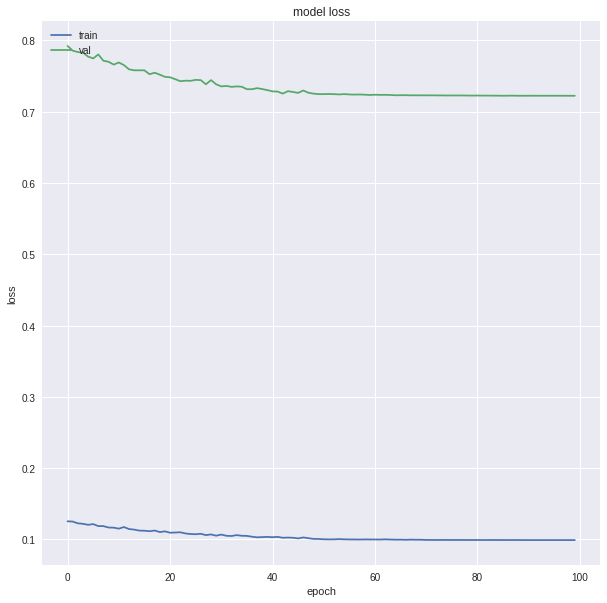

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model.save(os.path.join(gdrive_dir, 'boundary_predict_GRNN_Keras.h5'), overwrite=True)

In [0]:
def tf_print(tensors, message=None):
    def print_message(x):
        sys.stdout.write(message + " %s\n" % x)
        return x

    prints = [tf.py_func(print_message, [tensor], tensor.dtype) for tensor in tensors]

In [0]:
plt.rcParams['figure.figsize'] = (20,10)

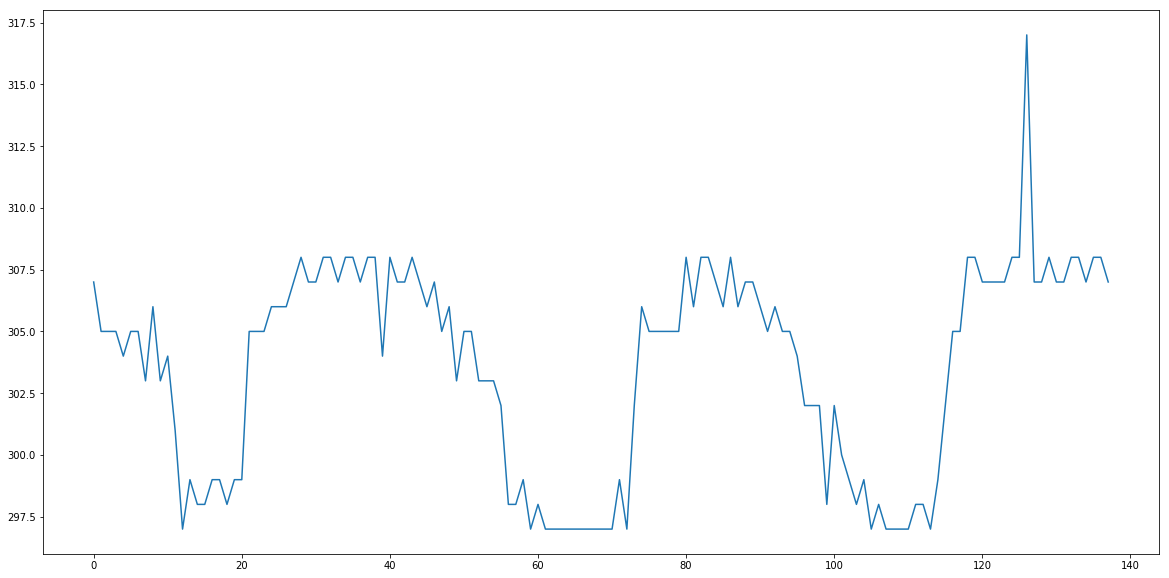

In [0]:
x = train_boundary_vectors[-138:, 0, 1]
plt.plot(x)

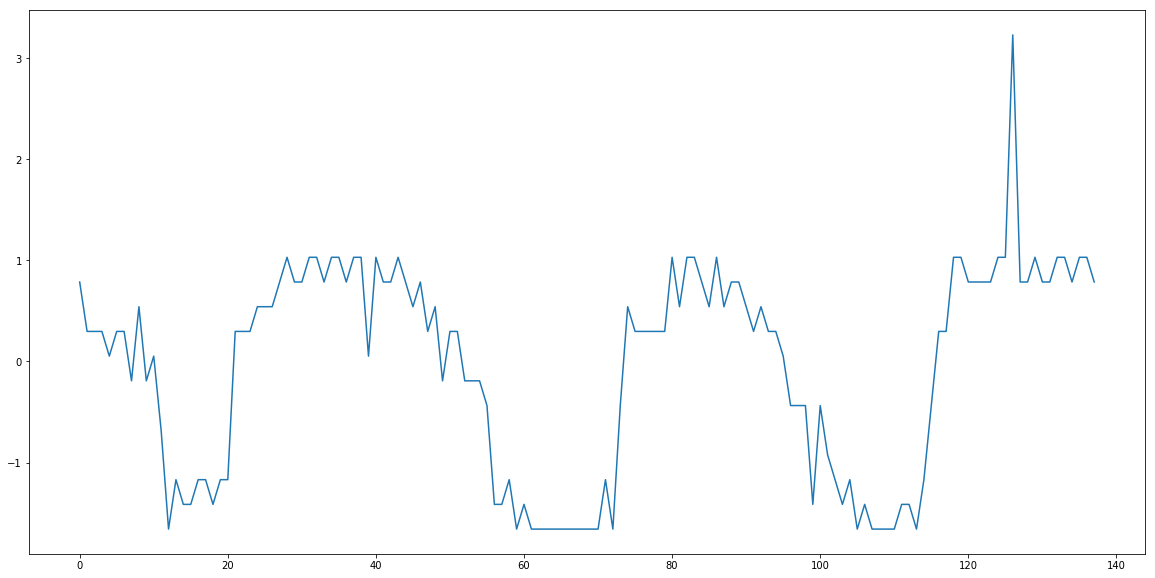

In [0]:
x = train_boundary_vectors_1[-138:, 0, 1]
plt.plot(x)

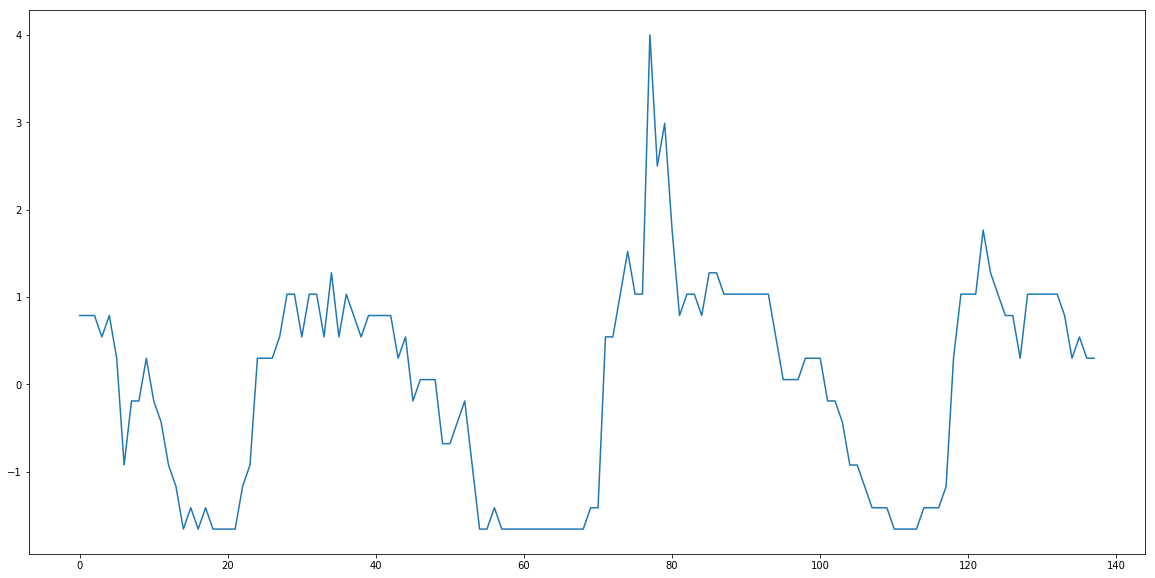

In [0]:
x2 = val_boundary_vectors_1[:, 0, 1]
x2[np.argmax(x2)] = 4
plt.plot(x2)

In [0]:
np.argmax(train_boundary_vectors[:,0,1]), np.argmax(train_boundary_vectors_1[:,0,1])

(426, 327)

In [0]:
z = train_boundary_vectors[:, 0, 1]
np.mean(z), np.std(z)

(303.783105022831, 4.089298590415346)

In [0]:
zz = train_boundary_vectors[:, :2, :]
zz_mean, zz_std = find_mean_std(zz)

In [0]:
zz_mean

array([[279.93835616],
       [279.94292237],
       [279.82191781],
       [280.4109589 ]])

In [0]:
np.mean(zz[:, 0, 0])

256.0

In [0]:
np.mean(zz[:, 0, 1])

303.783105022831

In [0]:
def find_mean_std(data):
    old_shape = data.shape
    data = data.reshape(old_shape[1]*old_shape[2], -1)
    mean = np.mean(data, axis=-1).reshape(-1, 1)
    std = np.std(data, axis=-1).reshape(-1, 1)
    std[std == 0] = 1
    #mean = mean.reshape(-1, old_shape[-1])
    #std = std.reshape(-1, old_shape[-1])
    return mean, std

In [0]:
ab = np.random.randn(2,3)
np.mean(ab, axis=0)

array([ 1.77707561, -0.31458146, -0.44041548])

In [0]:
ab = np.arange(24).reshape(4,3,2)

In [0]:
ab

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]],

       [[12, 13],
        [14, 15],
        [16, 17]],

       [[18, 19],
        [20, 21],
        [22, 23]]])

In [0]:
ab_mean, ab_std = find_mean_std(ab)

In [0]:
ab_mean

array([[ 1.5],
       [ 5.5],
       [ 9.5],
       [13.5],
       [17.5],
       [21.5]])

In [0]:
ab[:, 0, 0]

array([ 0,  6, 12, 18])

In [0]:
ab_1 = ab.reshape(4, 6)
ab_1

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23]])

In [0]:
np.mean(ab_1, axis=0)

array([ 9., 10., 11., 12., 13., 14.])

In [49]:
import numpy as np
import matplotlib.pyplot as plt

x, y = np.random.random(size=(2,10))

In [47]:
x.shape

(10,)

In [44]:
y1 = gtruth.reshape(1, -1)
y2 = np.tile(y1, [2,1])

In [45]:
y2.shape

(2, 92)

In [46]:
len(y2)

2

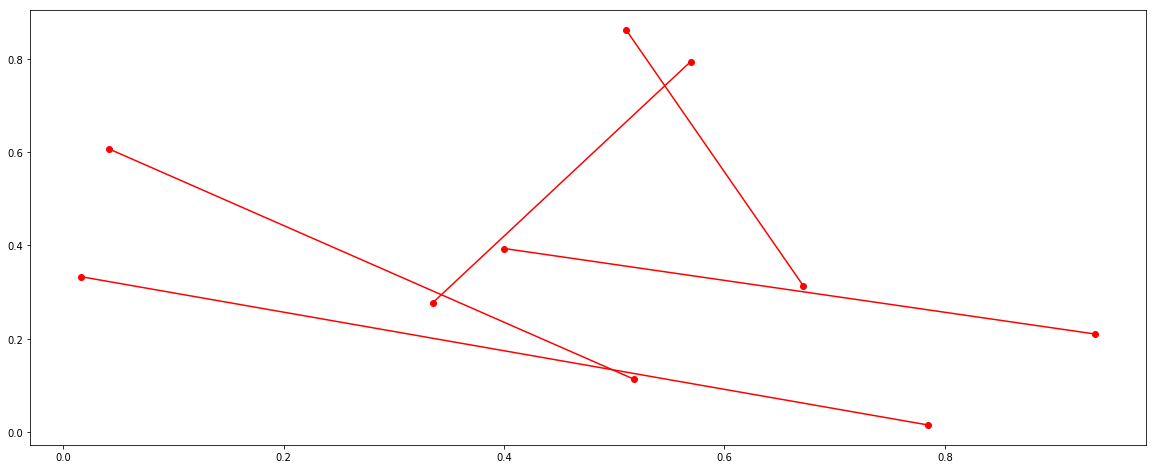

In [40]:
for i in range(0, len(x), 2):
    plt.plot(x[i:i+2], y[i:i+2], 'ro-')

plt.show()